# 4. Rapidly Exploring Random Tree

In [122]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from random import randint

## Upload the image ECMAP.png

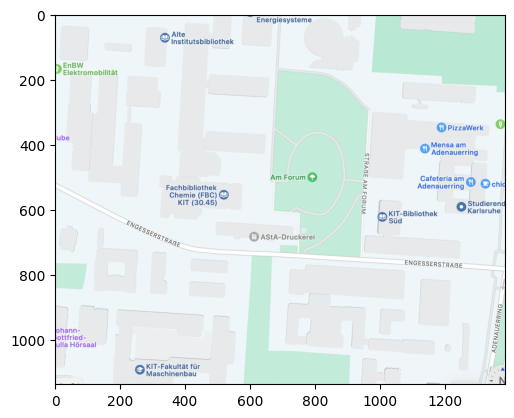

In [123]:
cdata = cv2.imread('KIT_map.png') #use cv2 to import the image 'KIT_map.png'
plt.imshow(cdata, cmap='gray')


## Chose the starting and target points and show them on the map

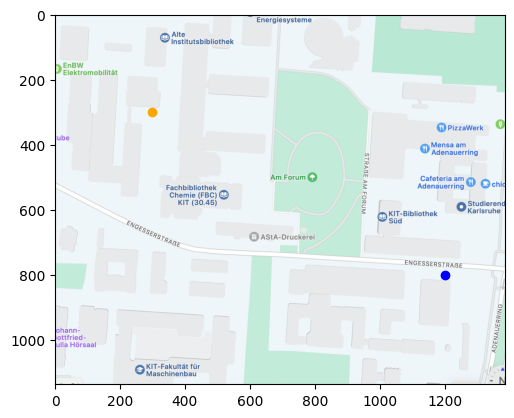

In [124]:
#Start point and target point
start = np.array([300,300])  #initialize start point coordinates 
end = np.array([1200,800]) #initialize end point coordinates 

# Show the image
plt.imshow(cdata, cmap='gray')

# Add the start point and the end point on the image
plt.scatter(start[0], start[1], color='orange', marker='o', label='Start')
plt.scatter(end[0], end[1], color='blue', marker='o', label='End')

# Mostra il grafico
plt.show()

## Some preprocessing of our map .. ;)

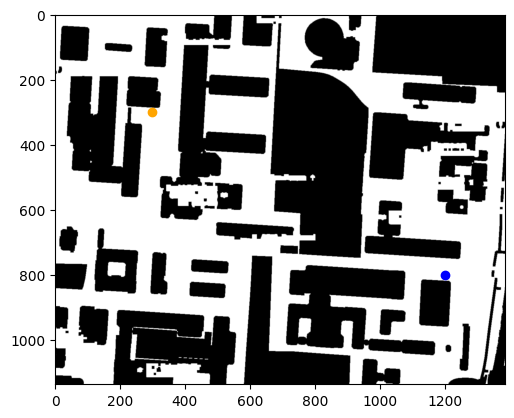

In [125]:
# Convert the image into a grayscale image
I = cv2.cvtColor(cdata, cv2.COLOR_BGRA2GRAY)
#convert into binary image with the correct threshold
_, BW = cv2.threshold(I, 0.95*255, 1, cv2.THRESH_BINARY)
# Invert binary image
BW2 = cv2.bitwise_not(BW)
# Remove small less than 500 pixels) connected components
BW3 = cv2.morphologyEx(BW2, cv2.MORPH_OPEN, np.ones((8, 8), np.uint8), iterations=1) # Remove small (less than 500 pixels) connected components
#Reverse the open image
BW4 = cv2.bitwise_not(BW3)
# Filling empty holes in the image
BW5 = cv2.bitwise_not(cv2.bitwise_not(BW4) - cv2.dilate(BW4, np.ones((3, 3), np.uint8), iterations=1)) 

BW5= (BW5 - np.min(BW5)) / (np.max(BW5) - np.min(BW5))

plt.imshow(BW5, cmap = 'gray')
plt.scatter(start[0], start[1], color='orange', marker='o', label='Start')
plt.scatter(end[0], end[1], color='blue', marker='o', label='End')

## RRT Function

In [126]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

def distance(a, b):
    return np.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)

def rand_node(w, h):
    return Node(randint(0, w - 1), randint(0, h - 1))

def closest_node(node, nodes):
    close_nodes = sorted(nodes, key=lambda n: distance(node, n))
    return close_nodes[0]

def new_node(direction, close_point, step=10):
    dist = distance(direction, close_point)
    if dist > step:
        prop_x = close_point.x + (direction.x - close_point.x) * step / dist
        prop_y = close_point.y + (direction.y - close_point.y) * step / dist
        return Node(int(prop_x), int(prop_y))
    else:
        return direction

def collision(node, map):
    return map[int(node.y), int(node.x)] == 0

def rrt(map, start, end, iteration=5000, step=8):
    w, h = map.shape
    start_node = Node(start[0], start[1])
    end_node = Node(end[0], end[1])
    nodes = [start_node]
    every_nodes = [start_node]  # Variable to save all nodes

    for i in range(iteration):
        rnd_node = rand_node(w, h) if randint(0, 100) > 50 else end_node
        close_node = closest_node(rnd_node, nodes)
        new_prop_node = new_node(rnd_node, close_node, step)

        if not collision(new_prop_node, map):
            new_prop_node.parent = close_node
            nodes.append(new_prop_node)
            every_nodes.append(new_prop_node)  # Add the new node to the list of all nodes

            if distance(new_prop_node, end_node) < step:
                end_node.parent = new_prop_node
                nodes.append(end_node)
                every_nodes.append(end_node)  # Add the final node if reached
                break

    path = []
    current_node = end_node
    while current_node.parent is not None:
        path.append((current_node.x, current_node.y))
        current_node = current_node.parent
    path.append((start_node.x, start_node.y))

    return path[::-1], every_nodes  # Returns both the route and all nodes



## Set start and target point and compute the path thorugh the rrt 

In [127]:
# Run RRT and get all nodes
path, every_nodes = rrt(BW5, start, end)


## Drawing the RRT tree

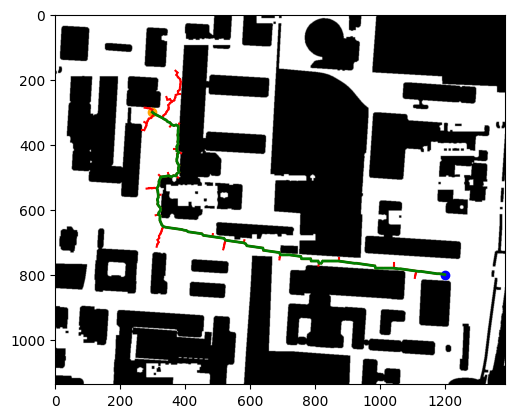

In [128]:
# Draw tree
def draw_tree(nodes):
    plt.imshow(BW5, cmap='gray', origin='lower')
    for node in nodes:
        if node.parent:
            plt.plot([node.x, node.parent.x], [node.y, node.parent.y], 'r-')

# Draw path
def draw_path(path):
    plt.imshow(BW5, cmap='gray', origin='lower')
    xs, ys = zip(*path)  # Create separate lists for x and y co-ordinates
    plt.plot(xs, ys, 'g-', linewidth=2)

# Draw the tree and the path
draw_tree(every_nodes)
draw_path(path)

plt.scatter(start[0], start[1], color='orange', marker='o', label='Start')
plt.scatter(end[0], end[1], color='blue', marker='o', label='End')

plt.gca().invert_yaxis()
plt.show()


### Is the path reaching the target? if not run the code again ;)
